*Experiments*

In [3]:
# Add the root directory to the sys.path
import sys
import os

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '../../'))
sys.path.append(root_dir)

print(f"Root directory added to sys.path: {root_dir}")



Root directory added to sys.path: c:\Users\Admin\Documents\GitHub\FederatedLearning


In [16]:
'''
This file can be used to generate parameters. Analysis is done in a seperate file.
'''

import sys
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm


# Import local modules
from src.utils import parse_run, set_global_seed, get_filenames, read_from_file, dict_list_to_dict_tensor
from src.plots import plot_reconstruction
from src.metrics.metrics import SSIM, LPIPS, PSNR, MSE

# Initialize seed
seed = 42
set_global_seed(seed=seed)

#################################################################################################################
#                           PARSE WIEGHTS, HYPER PARAMETERS AND DATA CONFIGURATIONS                             #
#################################################################################################################

run_path=r'C:\Users\Admin\Documents\GitHub\FederatedLearning\results\Data_size_test\test_1\160\\'
# C:\Users\Admin\Documents\GitHub\FederatedLearning\results\Batch_test\2_1_1_1\\'
#C:\Users\Admin\Documents\GitHub\FederatedLearning\results\Max_epoch_batch_test\test1

reconstructions_path = run_path + 'reconstruction/'
reconstructions_files = get_filenames(reconstructions_path)

df_dict = {
    'server_round' : [],
    'client_id' : [],
    # 'epochs' :  [],
    'batch_size' : [],
    'num_batches' : [],
    'predicted_images' : [],
    'true_images' : []
}

# Loop through all of the parameter files
for reconstructions_file in tqdm(reconstructions_files, desc="Processing Reconstruction files"):
    client_reconstruction = read_from_file(reconstructions_path + reconstructions_file) # Not sure this works!
    for round in client_reconstruction:            
        df_dict['batch_size'].append(round['run_info']['batch_size'])
        df_dict['server_round'].append(round['run_info']['server_round'])
        # df_dict['epochs'].append(1.0)
        df_dict['client_id'].append(round['run_info']['client_id'])
        df_dict['num_batches'].append(round['run_info']['num_batches'])
        df_dict['predicted_images'].append(torch.Tensor(round['reconstruction']['predicted_images']))
        df_dict['true_images'].append(torch.Tensor(round['reconstruction']['true_images']))

# Create the dataframe        
df = pd.DataFrame(df_dict)

# Compute the metrics
df['psnr'] = df.apply(lambda x: PSNR(x['predicted_images'], x['true_images']), axis=1)
df['ssim'] = df.apply(lambda x: SSIM(x['predicted_images'], x['true_images']), axis=1)
df['lpips'] = df.apply(lambda x: LPIPS(x['predicted_images'], x['true_images']), axis=1)

# print(df)

# Plot the first row in the datafram. 
predicted_image_tensor = df.iloc[0]['predicted_images']
true_images_tensor = df.iloc[0]['true_images']
# plot_reconstruction(
# ground_truth_images=true_images_tensor,
# reconstructed_images=predicted_image_tensor)


Processing Reconstruction files: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


c:\Users\Admin\Documents\GitHub\FederatedLearning\env\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


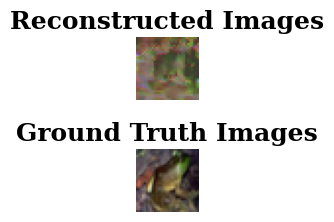

In [17]:
# Extract one tensor (e.g., the first image) from true_images_tensor
single_true_image = true_images_tensor[5]  # Select the first image

# Extract one tensor from predicted_image_tensor
single_predicted_image = predicted_image_tensor[5]  # Select the first image

# Plot the reconstruction for the selected image
plot_reconstruction(
    ground_truth_images=single_true_image.unsqueeze(0),  # Add batch dimension
    reconstructed_images=single_predicted_image.unsqueeze(0)  # Add batch dimension
)

In [6]:
df.head()

,server_round,client_id,batch_size,num_batches,predicted_images,true_images,psnr,ssim,lpips
0,1,11853098239603008490,160,1,"[[[tensor([0.5226, 0.5349, 0.5349, 0.5594, 0.5...","[[[tensor([0.5176, 0.6000, 0.6627, 0.6235, 0.6...",14.464116,0.236987,tensor(0.2414)
1,1,11989775189623990163,160,1,"[[[tensor([0.5670, 0.5799, 0.5892, 0.5926, 0.6...","[[[tensor([0.3725, 0.3882, 0.4157, 0.4157, 0.4...",14.322630,0.227699,tensor(0.2417)
2,1,14813481891374448900,160,1,"[[[tensor([0.2624, 0.3172, 0.3747, 0.3526, 0.3...","[[[tensor([0.6471, 0.6157, 0.6196, 0.6157, 0.4...",13.576590,0.199202,tensor(0.2935)
3,1,17272664019153141775,160,1,"[[[tensor([0.7235, 0.7463, 0.7466, 0.2415, 0.2...","[[[tensor([0.1882, 0.2588, 0.2157, 0.2078, 0.2...",13.931305,0.218624,tensor(0.2454)
4,1,3420589111233396065,160,1,"[[[tensor([0.4761, 0.5145, 0.5111, 0.5656, 0.5...","[[[tensor([0.5176, 0.5765, 0.6118, 0.5922, 0.7...",13.852102,0.215574,tensor(0.2664)


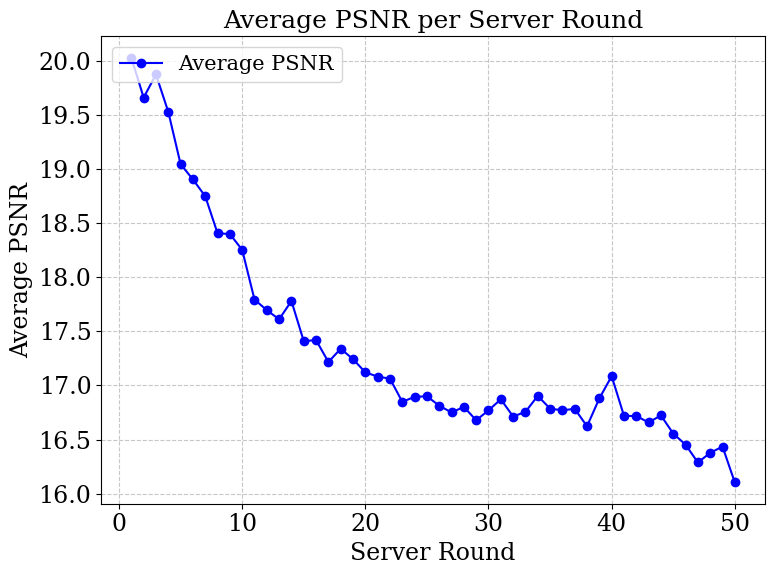

In [ ]:
import matplotlib.pyplot as plt

# Group by 'server_round' and calculate the average PSNR for each round
avg_psnr_per_round = df.groupby('server_round')['psnr'].mean()

# Plot the average PSNR for each round
plt.figure(figsize=(8, 6))
plt.plot(avg_psnr_per_round.index, avg_psnr_per_round.values, marker="o", linestyle="-", color="b", label="Average PSNR")
plt.xlabel("Server Round", loc="center")
plt.ylabel("Average PSNR", loc="center")
plt.title("Average PSNR per Server Round", loc="center")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [14]:
# Compute the average of each metric
average_psnr = df['psnr'].mean()
average_ssim = df['ssim'].mean()
average_lpips = df['lpips'].mean()

# Print the averages
print(f"Average PSNR: {average_psnr}")
print(f"Average SSIM: {average_ssim}")
print(f"Average LPIPS: {average_lpips}")

Average PSNR: 14.124723720550538
Average SSIM: 0.2276037484407425
Average LPIPS: 0.24684572219848633


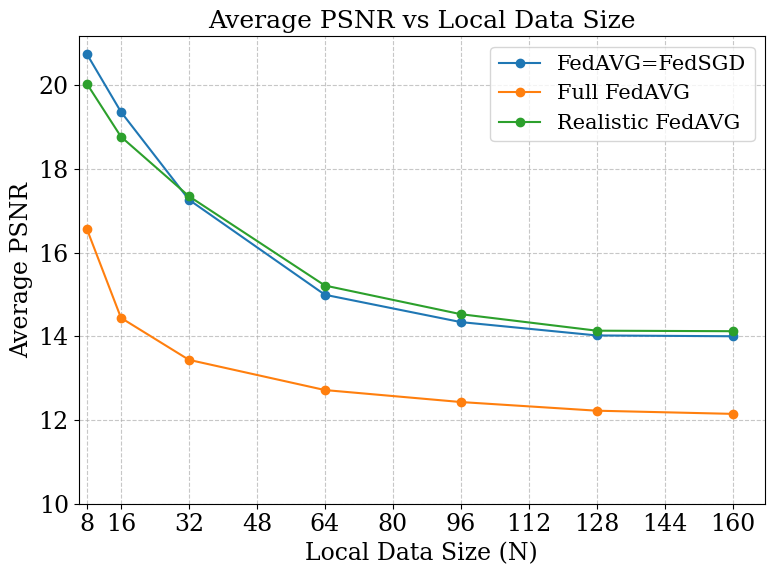

In [15]:
# Example data
local_data_sizes = [8, 16, 32, 64, 96, 128, 160]  # Local data sizes (N)
psnr_test_1 = [20.7449, 19.3668, 17.2679, 14.9962, 14.3425, 14.0233, 14.0038]  # PSNR values for experiment 1
psnr_test_2 = [16.5585, 14.4429, 13.4398, 12.7177, 12.4311, 12.2241, 12.1482]  # PSNR values for experiment 2
psnr_test_3 = [20.0363, 18.7735, 17.3515, 15.2163, 14.5313, 14.1370, 14.1247]  # PSNR values for experiment 3

# Combine PSNR values into a list of lists
psnr_values_list = [psnr_test_1, psnr_test_2, psnr_test_3]

# Labels for the lines
labels = ["FedAVG=FedSGD", "Full FedAVG", "Realistic FedAVG"]

# Call the plot function
plot_psnr_vs_N_size(local_data_sizes, psnr_values_list, labels)

In [8]:
import matplotlib.pyplot as plt
def plot_psnr_vs_N_size(local_data_sizes, psnr_values_list, labels, title="Average PSNR vs Local Data Size"):
    """
    Plots the average PSNR values against local data sizes for multiple configurations.

    Args:
        local_data_sizes (list): A list of local data sizes (x-axis values).
        psnr_values_list (list of lists): A list containing multiple lists of PSNR values (y-axis values).
        labels (list): A list of labels for each line in the plot.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))

    # Plot each PSNR list
    for psnr_values, label in zip(psnr_values_list, labels):
        plt.plot(local_data_sizes, psnr_values, marker="o", label=label)

    # Set plot labels and title
    plt.ylim(bottom=10)
    plt.xlim(left=6)
    plt.xticks([8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160])
    plt.xlabel("Local Data Size (N)", loc="center")
    plt.ylabel("Average PSNR", loc="center")
    plt.title(title, loc="center")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.savefig('plot1.pdf', format='pdf')
    plt.show()

In [ ]:
# predicted_image_tensor_fullAVG= predicted_image_tensor

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import torch
# width = 6  # Adjust to match \columnwidth
# height = 3 # Aspect ratio (4:3)
# FIGSIZE = (width, height)
# mpl.rcParams.update({
#     "text.usetex": False,  # Use LaTeX rendering for text
#     "font.family": "serif",
#     "font.size": 5,  # Adjust based on LaTeX document class
#     "axes.labelsize": 10,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "legend.fontsize": 8,
# })

# def plot_reconstruction(ground_truth_images: torch.Tensor, reconstructed_images: torch.Tensor, reconstructed_images2: torch.Tensor, figsize=FIGSIZE) -> None:
#     '''Function to plot ground truth and reconstructed images.
#     Tensors should be of shape (batch_size, C, H, W).
#     '''

#     assert ground_truth_images.shape == reconstructed_images.shape, "The input tensors must have the same shape"

#     batch_size = ground_truth_images.shape[0]

#     # Create subplots
#     _, axes = plt.subplots(3, batch_size, figsize=(figsize[0], figsize[1]))

#     # Ensure `axes` is always a 2D array
#     if batch_size == 1:
#         axes = axes[:, None]  # Convert 1D array to 2D (shape: (2, 1))

#     # Add titles for each row
#     axes[0, 0].set_title("Epoch = 1, Batch size = full", fontweight='bold', loc='left', fontsize=5)
#     axes[1, 0].set_title("Epoch = 20, Batch size = 1", fontweight='bold', loc='left', fontsize=5)
#     axes[2, 0].set_title("Ground Truth Images", fontweight='bold', loc='left', fontsize=5)

#     for i in range(batch_size):
        
#         axes[0, i].imshow(reconstructed_images[i].permute(1, 2, 0).cpu())
#         axes[0, i].axis('off')
#         axes[1, i].imshow(reconstructed_images2[i].permute(1, 2, 0).cpu())
#         axes[1, i].axis('off')
#         axes[2, i].imshow(ground_truth_images[i].permute(1, 2, 0).cpu())
#         axes[2, i].axis('off')

#     # Adjust layout for better spacing
#     plt.subplots_adjust(hspace=0, wspace=0)  # No space between images
#     plt.tight_layout(pad=0)  # Ensure tight layout without paddin
#     plt.tight_layout()
#     plt.savefig('plot.pdf', format='pdf')
#     plt.show()

c:\Users\Admin\Documents\GitHub\FederatedLearning\env\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


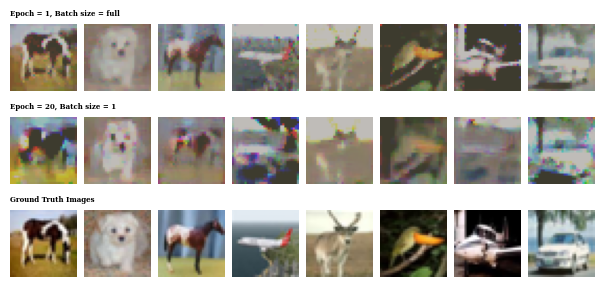

In [ ]:
# plot_reconstruction(
# ground_truth_images=true_images_tensor,
# reconstructed_images2=predicted_image_tensor_fullAVG,reconstructed_images=predicted_image_tensor)

In [ ]:
# # Compute the average of each metric
# average_psnr = df['psnr'].mean()
# average_ssim = df['ssim'].mean()
# average_lpips = df['lpips'].mean()

# # Print the averages
# print(f"Average PSNR: {average_psnr}")
# print(f"Average SSIM: {average_ssim}")
# print(f"Average LPIPS: {average_lpips}")

Average PSNR: 20.721381759643556
Average SSIM: 0.7437461197376252
Average LPIPS: 0.06529936790466309
